In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import keras
from glob import glob
from PIL import Image

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


# Preprocessing Data

In [3]:
data_dir = r'C:\Users\Owner\Desktop\COGS 118B Final Project\Data'
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}

lesion_dict = {
    'akiec': 'Actinic keratoses',
    'bcc': 'Basal cell carcinoma',
    'bkl': 'Benign keratosis-like lesions ',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma',
    'nv': 'Melanocytic nevi',
    'vasc': 'Vascular lesions',
}

lesion_df = pd.read_csv(os.path.join(r'C:\Users\Owner\Desktop\COGS 118B Final Project\Data', 'HAM10000_metadata.csv'))

# Add path to image file
lesion_df['path'] = lesion_df['image_id'].map(imageid_path_dict.get)

# Add human-readable cell type
lesion_df['cell_type'] = lesion_df['dx'].map(lesion_dict.get) 

# Assign codes 0-6 to lesions [0 = akiec, ... , 6 = vasc]
lesion_df['cell_type_idx'] = pd.Categorical(lesion_df['cell_type']).codes

In [4]:
lesion_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:\Users\Owner\Desktop\COGS 118B Final Project...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:\Users\Owner\Desktop\COGS 118B Final Project...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:\Users\Owner\Desktop\COGS 118B Final Project...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:\Users\Owner\Desktop\COGS 118B Final Project...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:\Users\Owner\Desktop\COGS 118B Final Project...,Benign keratosis-like lesions,2


In [5]:
lesion_df.shape

(10015, 10)

In [6]:
lesion_df['cell_type'].value_counts()

Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64

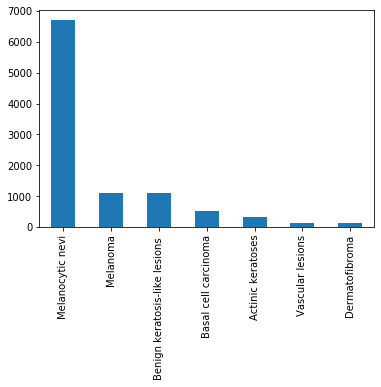

In [7]:
lesion_df['cell_type'].value_counts().plot(kind='bar')
plt.show()

In [8]:
#lesion_df = lesion_df.drop(lesion_df[lesion_df.cell_type_idx == 4].iloc[:5000].index)

In [9]:
lesion_df['cell_type'].value_counts()

Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64

In [10]:
lesion_df[lesion_df.cell_type_idx == 4].iloc[0]

lesion_id                                              HAM_0001751
image_id                                              ISIC_0024698
dx                                                              nv
dx_type                                                  consensus
age                                                             70
sex                                                           male
localization                                                  face
path             C:\Users\Owner\Desktop\COGS 118B Final Project...
cell_type                                         Melanocytic nevi
cell_type_idx                                                    4
Name: 64, dtype: object

In [11]:
lesion_df.shape

(10015, 10)

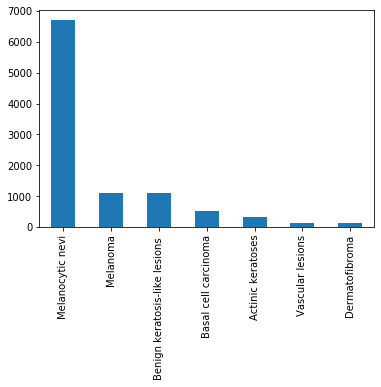

In [12]:
lesion_df['cell_type'].value_counts().plot(kind='bar')
plt.show()

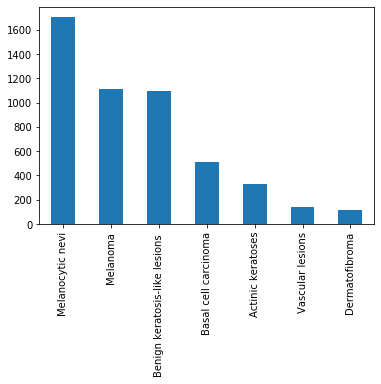

In [13]:
test_df = lesion_df.drop(lesion_df[lesion_df.cell_type_idx == 4].iloc[:5000].index)
test_df['cell_type'].value_counts().plot(kind='bar')
plt.show()

In [14]:
lesion_df['image'] = lesion_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [15]:
lesion_df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    10015
Name: image, dtype: int64

In [16]:
lesion_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:\Users\Owner\Desktop\COGS 118B Final Project...,Benign keratosis-like lesions,2,"[[[191, 153, 194], [191, 154, 198], [189, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:\Users\Owner\Desktop\COGS 118B Final Project...,Benign keratosis-like lesions,2,"[[[23, 13, 22], [25, 15, 24], [24, 16, 31], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:\Users\Owner\Desktop\COGS 118B Final Project...,Benign keratosis-like lesions,2,"[[[186, 126, 136], [190, 136, 149], [195, 137,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:\Users\Owner\Desktop\COGS 118B Final Project...,Benign keratosis-like lesions,2,"[[[24, 11, 18], [27, 13, 26], [39, 23, 33], [6..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:\Users\Owner\Desktop\COGS 118B Final Project...,Benign keratosis-like lesions,2,"[[[136, 91, 114], [148, 104, 127], [161, 117, ..."


In [17]:
y = lesion_df.cell_type_idx

x_train_df, x_test_df, y_train, y_test = train_test_split(lesion_df, y, test_size=0.15)

x_train = np.asarray(x_train_df['image'].tolist())
x_test = np.asarray(x_test_df['image'].tolist())
y_train = np.asarray(y_train.tolist())
y_test = np.asarray(y_test.tolist())

# One hot encoding for binary_crossentropy REMOVE AND USE 
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

# Normalize Data

In [18]:
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_test_mean) / x_test_std

In [19]:
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, 3, activation='relu', input_shape=input_shape))
model.add(Conv2D(32, 3, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, 3, activation='relu', input_shape=input_shape))
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.3))

model.add(Conv2D(128, 3, activation='relu', input_shape=input_shape))
model.add(MaxPooling2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


In [20]:
# WE CAN CHOOSE OPTIMIZER AND LOSS
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 98, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 71, 96, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 35, 48, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 35, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 46, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 22, 64)        0

In [22]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

In [23]:
epochs = 30
batch_size = 15

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

Train on 8512 samples, validate on 1503 samples
Epoch 1/30
8512/8512 [==============================] - 123s 14ms/sample - loss: 0.9793 - accuracy: 0.6700 - val_loss: 1.0016 - val_accuracy: 0.6813
Epoch 2/30
8512/8512 [==============================] - 116s 14ms/sample - loss: 0.8603 - accuracy: 0.6850 - val_loss: 0.9573 - val_accuracy: 0.6933
Epoch 3/30
8512/8512 [==============================] - 116s 14ms/sample - loss: 0.8246 - accuracy: 0.7047 - val_loss: 0.7919 - val_accuracy: 0.7059
Epoch 4/30
8512/8512 [==============================] - 116s 14ms/sample - loss: 0.7774 - accuracy: 0.7157 - val_loss: 0.8162 - val_accuracy: 0.7206
Epoch 5/30
8512/8512 [==============================] - 117s 14ms/sample - loss: 0.7451 - accuracy: 0.7263 - val_loss: 0.7468 - val_accuracy: 0.7259
Epoch 6/30
8512/8512 [==============================] - 117s 14ms/sample - loss: 0.7259 - accuracy: 0.7324 - val_loss: 0.7234 - val_accuracy: 0.7305
Epoch 7/30
8512/8512 [==============================] - 11

In [27]:
epochs = 20
batch_size = 30

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

Train on 8512 samples, validate on 1503 samples
Epoch 1/20
8512/8512 [==============================] - 111s 13ms/sample - loss: 0.2723 - accuracy: 0.8977 - val_loss: 0.8668 - val_accuracy: 0.7425
Epoch 2/20
8512/8512 [==============================] - 112s 13ms/sample - loss: 0.2395 - accuracy: 0.9121 - val_loss: 0.8566 - val_accuracy: 0.7538
Epoch 3/20
8512/8512 [==============================] - 113s 13ms/sample - loss: 0.2429 - accuracy: 0.9113 - val_loss: 0.8674 - val_accuracy: 0.7425
Epoch 4/20
8512/8512 [==============================] - 115s 13ms/sample - loss: 0.2349 - accuracy: 0.9155 - val_loss: 0.8883 - val_accuracy: 0.7498
Epoch 5/20
8512/8512 [==============================] - 113s 13ms/sample - loss: 0.2386 - accuracy: 0.9125 - val_loss: 0.8734 - val_accuracy: 0.7432
Epoch 6/20
8512/8512 [==============================] - 114s 13ms/sample - loss: 0.2285 - accuracy: 0.9184 - val_loss: 0.8960 - val_accuracy: 0.7532
Epoch 7/20
8512/8512 [==============================] - 11

In [24]:
loss, accuracy = model.evaluate(x_test, y_test)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

1503/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test: accuracy = 0.749168  ;  loss = 0.822730


In [25]:
model.save('CNN')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: CNN\assets


KeyError: 'acc'

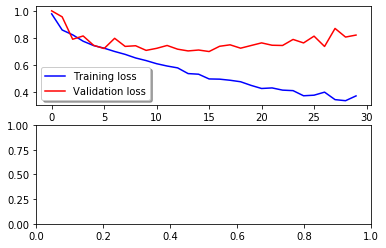

In [26]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)